# Photometry in Python - Photutils, DAOFIND, and Aperture Photometry

This notebook is based on a series created by Stuart Littlefair at the University of Sheffield. 
It also makes use of 'phot_helpers.py', a set of useful scripts created by Stuart Littlefair for photometry.


## Steps

At the end of this notebook you should be able to measure magnitudes for stars in your calibrated Nickel images. 

The steps are:
1. finding the stars in our image;
1. measuring instrumental magnitudes (photometry);
1. Applying pre-calculated zeropoints to transform between instrumental and calibrated magnitudes
1. Plotting the results in a colour-magnitude diagram

# Setting up Astrometry.net

We will use astrometry.net to determine an astrometric solution for our images. 

An astrometric solution will allow us to transform pixel (X-Y) co-ordinates to RA-Dec co-ordinates for all of the stars in our image. 

Astrometry.net provide the source code, so we could build the application oursevles, and use their index images to determine our astrometric solution. But in practice, it's much easier to use their web service for our purposes.

To use astrometry.net's web-based servives we need an API key. The API key is a unique identifier telling astrometry.net who you are. 

<section class="challenge panel panel-success"> 
<div class="panel-heading">

<h2><span class="fa fa-pencil"></span> Set up astrometry.net API </h2>
    
**Create an account with astrometry.net:**
https://nova.astrometry.net/

**Then navigate to the 'API' tab. 
Copy your API key and add it below. Or you can add it to the 'astroquery.cfg' file, then move this file to ~/.astropy/config/**
    
</div>
</section>

In [1]:
from astroquery.astrometry_net import AstrometryNet
ast = AstrometryNet()
#ast.api_key = '##########'

# Photometry with Photutils

Many tools exist to perform photometry (IRAF, GAIA, AstroImageJ etc.)
We are going to be using the Python package [photutils](http://photutils.readthedocs.org/en/latest/) to do most of the heavy lifting for us.

If you do not have photutils already installed, the code cell below will install it. Run this cell, and if there are any **errors**, ask for help (warnings are ok/expected).

In [2]:
import sys
!{sys.executable} -m pip install photutils

In [3]:
## if this code cell runs without error, you have successfully installed photutils!
import photutils as p

# Functions for Aperture Photometry

Now we'll make a couple of functions to make life easier later. 

The first will perform aperture photometry. The second will plot the full-width at half-maximum for a star.

In [4]:
# A function to perform aperture photometry
from photutils.utils import calc_total_error
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
import astropy.stats as st
import warnings
from astropy.wcs import WCS
def aperture_photometry(data, header, sources, aperture_radius, sky_inner_radius, sky_outer_radius):
    """
    Calculate Aperture Photometry on a list of sources

    Parameters
    ----------
    data:  `np.ndarray`
        A 2D array of pixel values of your data. From a FITS file, you can create this array with
        `fits.getdata`.

    header: `~astropy.fits.Header`
        A FITS Header object. From a FITS file, you can create this object with
        `fits.getheader`.

    sources: `~astropy.table.Table`
        A table of detected sources for the image. Usually, `photutils.DAOStarFinder` would be
        used to create this list.

    aperture_radius: float
        Radius of the target aperture, in pixels

    sky_inner_radius: float
        Radius of the inner aperture that makes up the sky annulus

    sky_outer_radius: float
        Radius of the outer aperture that makes up the sky annulus

    Returns
    -------
    phot_table: `~astropy.table.Table`
        A table of measurements for each source, including instrumental magnitude and error.
    """
    # make apertures around sources, and annuli for sky estimation
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=aperture_radius)
    sky_annulus = CircularAnnulus(positions,
                                    r_in=sky_inner_radius, r_out=sky_outer_radius)
    annulus_masks = sky_annulus.to_mask(method='center')

    # aperture photometry - calculates total counts in apertures, with errors
    # calc_total_error uses CCD SNR equation 
    error_arr = calc_total_error(data, 12.0, egain)
    phot_table = p.aperture.aperture_photometry(data, apertures, error=error_arr)

    # calculate the Sky background. Because the sky annulus might have other
    # stars inside it, we will take a CLIPPED MEAN of the counts in the annulus
    # to try and reject the contribution from stars.
    bkg_mean = []
    for mask in annulus_masks:
        annulus_data = mask.multiply(data)
        annulus_data_1d = annulus_data[mask.data > 0]
        mean_sigclip, _, _ = st.sigma_clipped_stats(annulus_data_1d)
        bkg_mean.append(mean_sigclip)

    # now we know the mean sky counts. We multiply by ratio of annulus area to
    # target aperture area. This gives expected number of sky counts in target
    # aperture.
    bkg_mean = np.array(bkg_mean)
    phot_table['sky_mean'] = bkg_mean
    phot_table['aper_bkg'] = bkg_mean * apertures.area
    phot_table['aper_sum_bksub'] = phot_table['aperture_sum'] - phot_table['aper_bkg']

    # Tricky bit now! We want to know what Right Ascension and Declination
    # each pixel corresponds to. We will use the information in the FITS header
    # (the so-called "World Coordinate System") to work this out. 
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(header)
    ra, dec = wcs.all_pix2world(phot_table['xcenter'], phot_table['ycenter'], 0)
    phot_table['RA'] = ra
    phot_table['DEC'] = dec

    # Calculate Instrumental Magnitude and Error
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        phot_table['instrumental_mag'] = -2.5*np.log10(phot_table['aper_sum_bksub'] / header['EXPTIME'])
    phot_table['e_instrumental_mag'] = phot_table['aperture_sum_err'] / phot_table['aper_sum_bksub']

    return phot_table

In [5]:
# We will use this function later to measure FWHM in our images
def measure_FWHM(data, sources):
    # averagely bright stars
    lims = np.percentile(sources['flux'], (60, 70))
    mask = reduce(
        np.logical_and,
        (sources['flux'] > lims[0], sources['flux'] < lims[1],
         sources['xcentroid'] > 15, sources['ycentroid'] > 15,
         sources['xcentroid'] < data.shape[1]-15, 
         sources['ycentroid'] < data.shape[0]-15
        )
    )

    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    tree = KDTree(positions)
    # nearest neighbours
    dist, ind = tree.query(positions, 2)

    # most isolated star of proper brightness
    idx = dist[:, 1][mask].argmax()
    location = positions[mask][idx]
    cutout = Cutout2D(data, location.T, 15)

    fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
    norm = ImageNormalize(cutout.data, interval=AsymmetricPercentileInterval(1, 99))
    axis[0].imshow(cutout.data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
    axis[0].set_xlabel('X')
    axis[0].set_ylabel('Y')

    xc, yc = centroid_com(cutout.data)
    x = np.arange(15) - xc
    y = np.arange(15) - yc
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    axis[1].plot(R.ravel(), cutout.data.ravel(), '.')
    axis[1].set_xlabel('Distance from centre of star')
    axis[1].set_ylabel('Counts')


# Workflow

The basic steps that we will work through in this workbook are:
1. [Read in an image](#ReadImage)
2. [Indentify stars in the image](#SourceList)
3. [Measure the brightness of the stars in that image (aperture photometry)](#ApPhot)
4. [Repeat the above steps for other filters](#BFilt)
5. Determine photometric zeropoints using standard stars
6. Apply the photometric zeropoints to your measured magnitudes

<a id='ReadImage'></a>

# Read in your image

Using the code cell below, read in one of your pre-calibrated Nickel images with plenty of stars. A good choice would be a long exposure V-band image. We're going to read the image into an array called `data` and read the header from the FITS file into a variable called `header`. 

<section class="challenge panel panel-success"> 
<div class="panel-heading">

<h2><span class="fa fa-pencil"></span> Choose the image to use </h2>
    
**Set the input file (ifile) that you want to perform photometry on.**
    
</div>
</section>


In [6]:
from astropy.io import fits,ascii
import numpy as np
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import AsymmetricPercentileInterval
from matplotlib import pyplot as plt
from functools import reduce
from scipy.spatial import KDTree
from astropy.nddata import Cutout2D
from photutils.centroids import centroid_com

# We need to set the gain of our CCD to allow us to measure errors correctly later
# For the Nickel, gain is 2 e/ADU
egain = 2.0
ifile = '/home/jrees/DataReduction/20230720/Standards/d1115_os_bs_ff_bp_crj.fits'
data, header = fits.getdata(ifile,header=True)


<a id='SourceList'></a>
# Creating a Source List

The first step is to detect our sources. We will do this using an algorithm called DAOFIND ([Stetson 1987, PASP, 99, 191](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract)). DAOFIND looks for bright regions in the image that have a peak brightness greater than some threshold and that have a size and shape similar to a Gaussian of specified FWHM.

Stars in our image will stand out above the background, and DAOFIND will find them, but we need to know what threshold to use. One way of doing this is to measure the statistics of the **background** in our image. If we measure the average value of the background, and the amount the background varies, we can look for regions that are significantly brighter than background pixels. 

Below we will do that using a "sigma-clipped" mean - this estimates the average background and the standard deviation. We then throw away all the pixels more than 3 standard deviations (sigma) away from the mean, and repeat the process. We carry on until no pixels are more than 3 standard deviations away from the average value, then calculate the mean, median and standard deviation of the remaining pixels.

You may want to tweak this value of sigma until you're happy with the sky level.

In [7]:
# import sigma_clipping function from astropy
from astropy.stats import sigma_clipped_stats

mean_background, median_background, background_standard_deviation = sigma_clipped_stats(data, sigma=3.0)

print("The background has an average value of {:.1f} and a standard deviation of {:.1f} counts".format(
    mean_background, background_standard_deviation))

The background has an average value of 1043.7 and a standard deviation of 36.9 counts


# Finding Stars

Now we know how bright our background is, and how much it varies, let's look for stars that are brighter than the background plus 5 standard deviations. That should be enough that we don't identify bright background pixels as stars by accident. The DAOFIND algorithm needs a guess for how big the stars are - as a Gaussian FWHM - we'll guess at 6 pixels for now, but you can tweak this further.

In [8]:
from photutils.detection import DAOStarFinder

# Set the fwhm initial guess
fwhm = 6.0
# make a star finder object to look for stars with FWHM~6 pixels that are more than 5-sigma above background
daofind = DAOStarFinder(fwhm=fwhm, threshold=5*background_standard_deviation)

# Mask the data to remove the edges/corners
mask=np.ma.make_mask(data,copy=True,shrink=True,dtype=bool)
mask[:,:]=False
mask[950:,0:50]=True
mask[0:50,0:50]=True
mask[:,1010:]=True

# use it to find stars. We'll subtract the background off first, so background pixels have an average value of 0
sources = daofind(data - median_background,mask=mask)

print(sources)

 id     xcentroid          ycentroid      ...        peak               flux                 mag         
--- ------------------ ------------------ ... ------------------ ------------------ ---------------------
  1   406.156585179488  9.096097275094332 ...    3144.5966796875 19.819835662841797    -3.242750122974445
  2   705.594849925822  8.792201157108172 ... 1014.1324462890625 6.8197550773620605    -2.084421944537029
  3  838.0862026319151 14.432395044268628 ...   7031.52197265625  46.18302536010742    -4.161205948248263
  4  297.9239782853371 17.960807603395928 ...    125.84521484375 1.0509432554244995 -0.053948168468999046
  5 181.03355841047795 37.614237996741906 ... 1114.5499267578125 6.5456342697143555   -2.0398793397801795
  6  135.8807676558165 41.146427437410466 ...  257.1715087890625  2.000882625579834    -0.753054032737333
  7  407.7654921167904 49.650757111129195 ...  453.0579833984375 3.4295132160186768   -1.3380812020021011
  8  912.3730629186284 50.032672682220344 ... 

The ``sources`` variable contains a table of all the detected stars. There are various columns, but the ones we are interested in is the X and Y positions of the stars, which you can find with ```sources['xcentroid']``` and ```sources['ycentroid']```.

But how do we know we've found most of the stars? Or if we are mistakenly identifying bright background pixels as stars? We can inspect our sources by-eye. To make this easier, we're going to use one of the handy functions written by Stuart Littlefair 


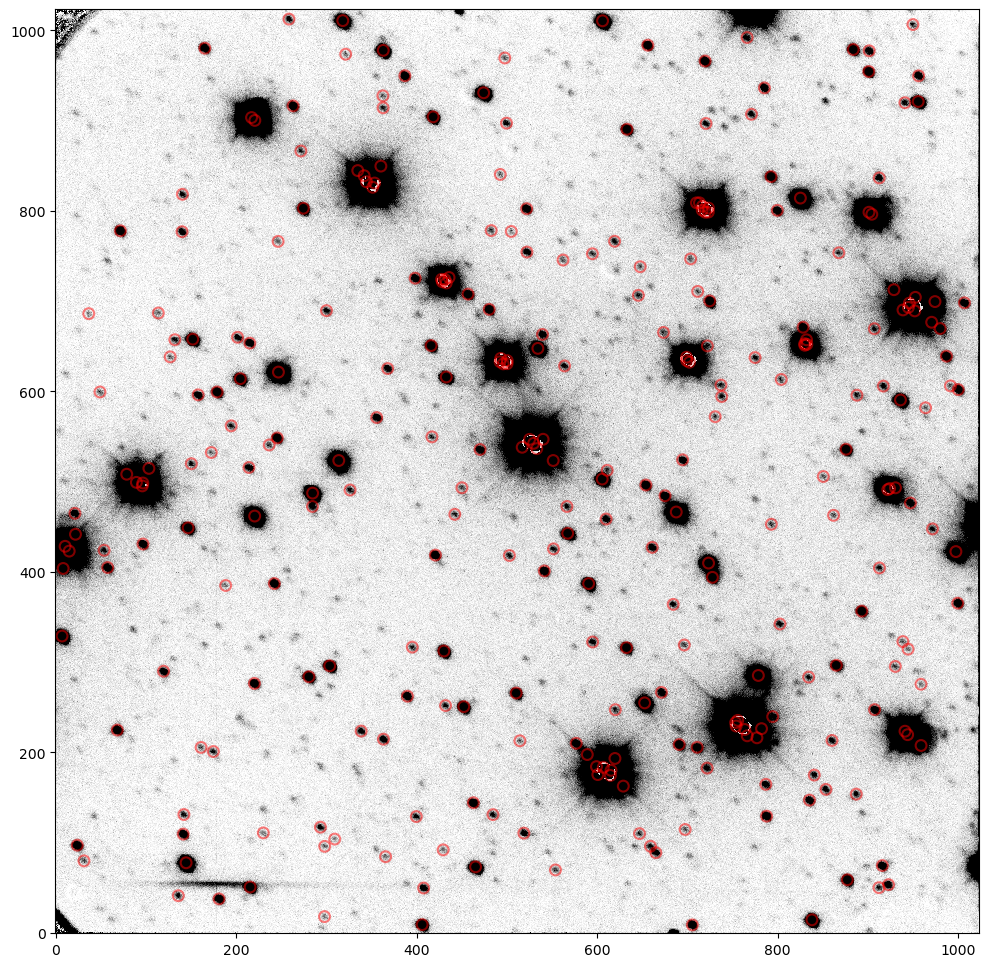

In [9]:
# How big should we make the red apertures (in pixels)?
radius=fwhm
# Set up the positions of stars (from DAOFIND) and the size of our apertures
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=radius)
# Normalise the image
norm = ImageNormalize(data, interval=AsymmetricPercentileInterval(5, 95))

fig = plt.figure(figsize=(15, 12))
apertures.plot(color='red', lw=1.5, alpha=0.5)
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')


# Tweak the detection settings

 The DAOFIND algorithm requires a threshold for star detection, and a typical FWHM of the stars in the images. Try different settings for these values, and see how they affect the detection of stars in your data. Make a decision about what values to use for this image.

# FWHM of stars in the image

We will also need an estimate for the FWHM of stars in the image. We can estimate this by-eye by plotting a bright, isolated, star and plotting the brightness against distance from the star's centre. 

Again, a handy tool exists to do this already. 

<section class="challenge panel panel-success"> 
<div class="panel-heading">

<h2><span class="fa fa-pencil"></span> Set up astrometry.net API </h2>
    
**Using the plot below, figure out your FWHM in pixels. Using the Nickel plate scale you can convert it to arcseconds (you do remember the value right?)**
    
</div>
</section>


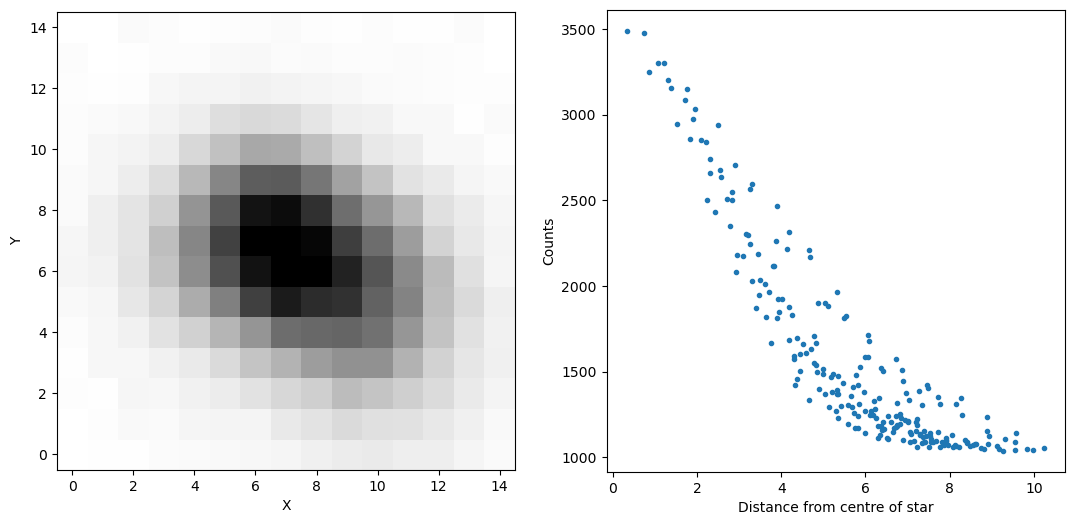

In [10]:
measure_FWHM(data, sources)

# Aperture Photometry

So, we have a list of detected sources and positions in the image, and an idea of the FWHM of stars in the image. Now we can perform aperture photometry on all of these sources. 
In brief the function performs the following steps:

1. Add up the counts from each source within a target aperture
2. Measure the sky brightness around each source using the sky annulus
3. Subtract the sky contribution from the counts in step 1.
4. Calculate instrumental magnitude from the counts and exposure time.


<a id='ApPhot'></a>
# Perform Aperture Photometry

You'll need to pick values for the aperture radii. 

Target apertures want to be big enough to accept a decent fraction of the flux, but not so large that the measurements are very noisy, or contaminated by nearby stars. As a rule of thumb this aperture might have a radius of 1.5-2x the FWHM.

Sky Annuli want to be wide enough to accurately measure the sky, but not so large that the annuli overlap nearby stars.

To get started, try values around 15, 25, 35 pixels for these apertures. We can tweak them later on.

If you want to view extra information about what 'aperture_photometry' is doing, you can do:

help(aperture_photometry)

In [11]:
Vmag_inst = aperture_photometry(data, header, sources, 15, 25, 35)


# Photometric Calibration

Now we have a table of instrumental magnitudes (and much besides) in it. The next step is photometric calibration. As a reminder, this involves finding the average value of the *difference* between the calibrated and instrumental magnitudes for all our stars.

There are a couple of options for determining our photometric calibration. Traditionally, we would observe 'standard stars', stars with well determined magnitudes. By observing these standard stars over a range of airmass we can determine the effect of atmospheric extinction, and determine photometric zeropoints as a function of airmass. 

This is a pretty involved process, and probably outside the scope of our data reduction activity this afternoon (though I have created the bare bones of an example in the nickel-standards notebook. 

With the advent of modern all-sky surveys we can also 'cheat' slightly, and use existing photometry from these all-sky surveys to provide our photometric calibrations. 

We will use the [APASS](https://www.aavso.org/apass) catalog; a catalog which combines several other sky surveys to provide data in many filters across much of the sky. Crucially, in this case it includes B, V, r, and i magnitudes, the filters used for our photometry (the r/i filters are not an exact match for our R and I filters, but close enough for this demonstration).

To perform the cross-matching we will use the [astroquery](https://astroquery.readthedocs.io/en/latest/) Python library. 

To perform the cross-match, we'll need to determine an astrometric solution for our data. The astrometric solution will allow us to convert x-y pixel co-ordinates to RA-Dec co-ordinates. 

In [12]:
from astropy import units as u
from astroquery.xmatch import XMatch

Could not import regions, which is required for some of the functionalities of this module.


Our photometry is stored as an astropy table, which is a handy object for reading and writing tabular data. These astropy tables play nicely with Jupyter notebooks, so you can simply type the name of the table in a code cell to see the table displayed in the browser.

In [13]:
Vmag_inst

<QTable length=298>
  id       xcenter            ycenter       ...         DEC           instrumental_mag    e_instrumental_mag 
             pix                pix         ...                                                              
int64      float64            float64       ...       float64             float64              float64       
----- ------------------ ------------------ ... ------------------- ------------------- ---------------------
    1   406.156585179488  9.096097275094332 ... -18.933989815803915 -7.7185986859854765 0.0019093905724925206
    2   705.594849925822  8.792201157108172 ... -18.932776451063788  -7.284385027287632 0.0026620731192323645
    3  838.0862026319151 14.432395044268628 ... -18.932830961647678   -8.26142121137596 0.0013263726437402067
    4  297.9239782853371 17.960807603395928 ...  -18.93532633445135  -7.132931993122921  0.003189827432811122
    5 181.03355841047795 37.614237996741906 ...  -18.93780436372324  -5.772202892386789  0.011532678853599154
    6  135.8807676558165 41.146427437410466 ... -18.938344334530044  -4.471728121541374   0.03743298234930831
    7  407.7654921167904 49.650757111129195 ... -18.938149424838798  -4.984698611659413  0.023392889988674073
  ...                ...                ... ...                 ...                 ...                   ...
  291  883.9168715130372  978.9090819049263 ... -19.031723122554233   -6.68154776218969  0.005176771500174652
  292  165.3068726965265   980.335005944553 ... -19.034706868920942  -5.916736917622849  0.010104744663275222
  293  656.2231071243172  983.6906382187636 ...   -19.0331168488626  -5.791429412605892  0.011331819304531818
  294  766.2745967888475   992.188957111946 ... -19.033554004092675 -3.6842637897857706   0.07960791526503502
  295  950.0486755907752 1006.5881162946683 ...  -19.03430363484096  -7.231872259453005 0.0029185757699040095
  296 318.17422315665226 1010.9401455179288 ... -19.037249946503216  -8.662473429586889 0.0010015859606722763
  297  606.0569267764062 1010.7208479695421 ...  -19.03609190042624   -8.73673352709927 0.0009544442810995597
  298 258.55357304036653  1012.630679953126 ...   -19.0376581139758  -7.250302607601516 0.0027714133765695645

# Astrometric Solution

To determine our astrometric solution we will make use of the Astrometry.net API. 

We already set up the API key earlier in this notebook, so now we can use solve_from_source_list to determine an astrometric solution from our source list.

In [14]:
from astropy.table import Table

# Sort sources in ascending order
sources.sort('flux')
# Reverse to get descending order
sources.reverse()

image_width = 1024
image_height = 1024
wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                        image_width, image_height,
                                        solve_timeout=120)
print("Finished astrometric solve")
print("-----------------------------------------------------")


Solving................Finished astrometric solve
-----------------------------------------------------


Now we need to apply the astrometric solution to our source table. 

In [15]:
w = WCS(wcs_header)
Vmag_inst['RA'], Vmag_inst['DEC'] = w.wcs_pix2world(Vmag_inst['xcenter'],Vmag_inst['ycenter'],1)


Our source table now has the measured centres of our stars in RA and Dec (**RA** and **DEC**) and the instrumental magnitude and uncertainty (**instrumental_mag** and **e_instrumental_mag**). Note that the magnitude uncertainty is calculated using the CCD signal-to-noise equation.

# Crossmatching with APASS (or some other catalogue)


 We need to calibrate our photometry, which will involve comparing our instrumental magnitudes to calibrated magnitudes measured for the same stars. We need to match our detected stars with those catalogued in the sky survey [APASS](https://www.aavso.org/apass). We are looking for stars who's RA and Dec matches to within some radius. A service called **Vizier** hosts online versions of astronomical catalogs, and we can use the ```Xmatch.query``` function to match an astropy table with a table hosted by Vizier using the code below.

 Run the code cell below, and note carefully how we specify the columns that contain RA and Dec in our *local* table, and how we set the maximum distance for a valid match. **II/336/apass9** is the name of the APASS catalog on Vizier. If you need to find the names of other catalogs (perhaps APASS doesn't cover the patch of sky containing your open cluster), you can enter the catalog name in the search box [here](http://vizier.u-strasbg.fr)
 Something like UCAC4 or UCAC5 or GAIA might be good alternative choices

 **The code cell below may take a while to run. Be patient...**
 

In [16]:
xmatch = XMatch.query(cat1=Vmag_inst, cat2='vizier:II/336/apass9', max_distance=2*u.arcsec, colRA1='RA', colDec1='DEC')


In [17]:
xmatch

<Table length=48>
angDist    id       xcenter            ycenter          aperture_sum    ... e_rpmag u_e_rpmag  ipmag  e_ipmag u_e_ipmag
float64  int64      float64            float64            float64       ... float64   int64   float64 float64   int64  
-------- ----- ------------------ ------------------ ------------------ ... ------- --------- ------- ------- ---------
1.401169     1   406.156585179488  9.096097275094332  802983.3605800661 ...   0.052         0   14.16   0.063         0
1.964272    13 465.33258048734575   73.1360202764238 1037479.9246103776 ...    0.04         0  14.525   0.075         0
0.435948    46  606.8358936186409 183.45407356061614  15349243.59201517 ...   0.164         0   9.879     0.0         1
1.995417    60  944.1799147547424 219.60060958609674 10268333.762529062 ...   0.035         0  10.675   0.148         0
 0.22987    64  941.2522609043265  223.4083901181619  10217611.32255314 ...   0.035         0  10.675   0.148         0
1.974863    66  754.1162501712116 229.21753565235005 17676738.200905085 ...     0.0         1      --      --        --
1.556603    67  753.5543481848795  233.0451074260029 16949525.435447592 ...     0.0         1      --      --        --
1.125591    68  755.8596493819923  235.4192163181043  17082860.31969943 ...     0.0         1      --      --        --
     ...   ...                ...                ...                ... ...     ...       ...     ...     ...       ...
  1.2378   246  719.9345396496866  798.5598547299733 10967267.168495819 ...   0.032         0  10.555    0.17         0
0.043276   247   723.253019406638  798.7416576449602 10939459.669045884 ...   0.032         0  10.555    0.17         0
1.603568   253  723.4339544644295  803.1320585343414  10965063.18711244 ...   0.032         0  10.555    0.17         0
1.710219   257   825.307521993631  814.2707633519852  2810404.414423612 ...   0.052         0    12.5   0.134         0
0.844264   259 351.34143358626085  826.2799681538916 13079322.849392846 ...   0.078         0  10.121   0.095         0
 1.04923   260  353.4130014852464  830.8958580235624  13224679.00475846 ...   0.078         0  10.121   0.095         0
0.705105   272 220.71313617195128   900.343023870475  9905223.444958199 ...   0.033         0  10.776   0.135         0
1.539917   279  955.8767372553376  921.3034573940441   1065508.63789581 ...   0.033         0  13.976   0.181         0

# Plot the difference and find the zero-point

 Plot the difference between instrumental and calibrated magnitude found above, against the calibrated V-band magnitude on the X-axis. You should see something like the figure below:

<img src="images/V_zeropoint.png" style="margin: 0px" width=750px/>

<function matplotlib.pyplot.show(close=None, block=None)>

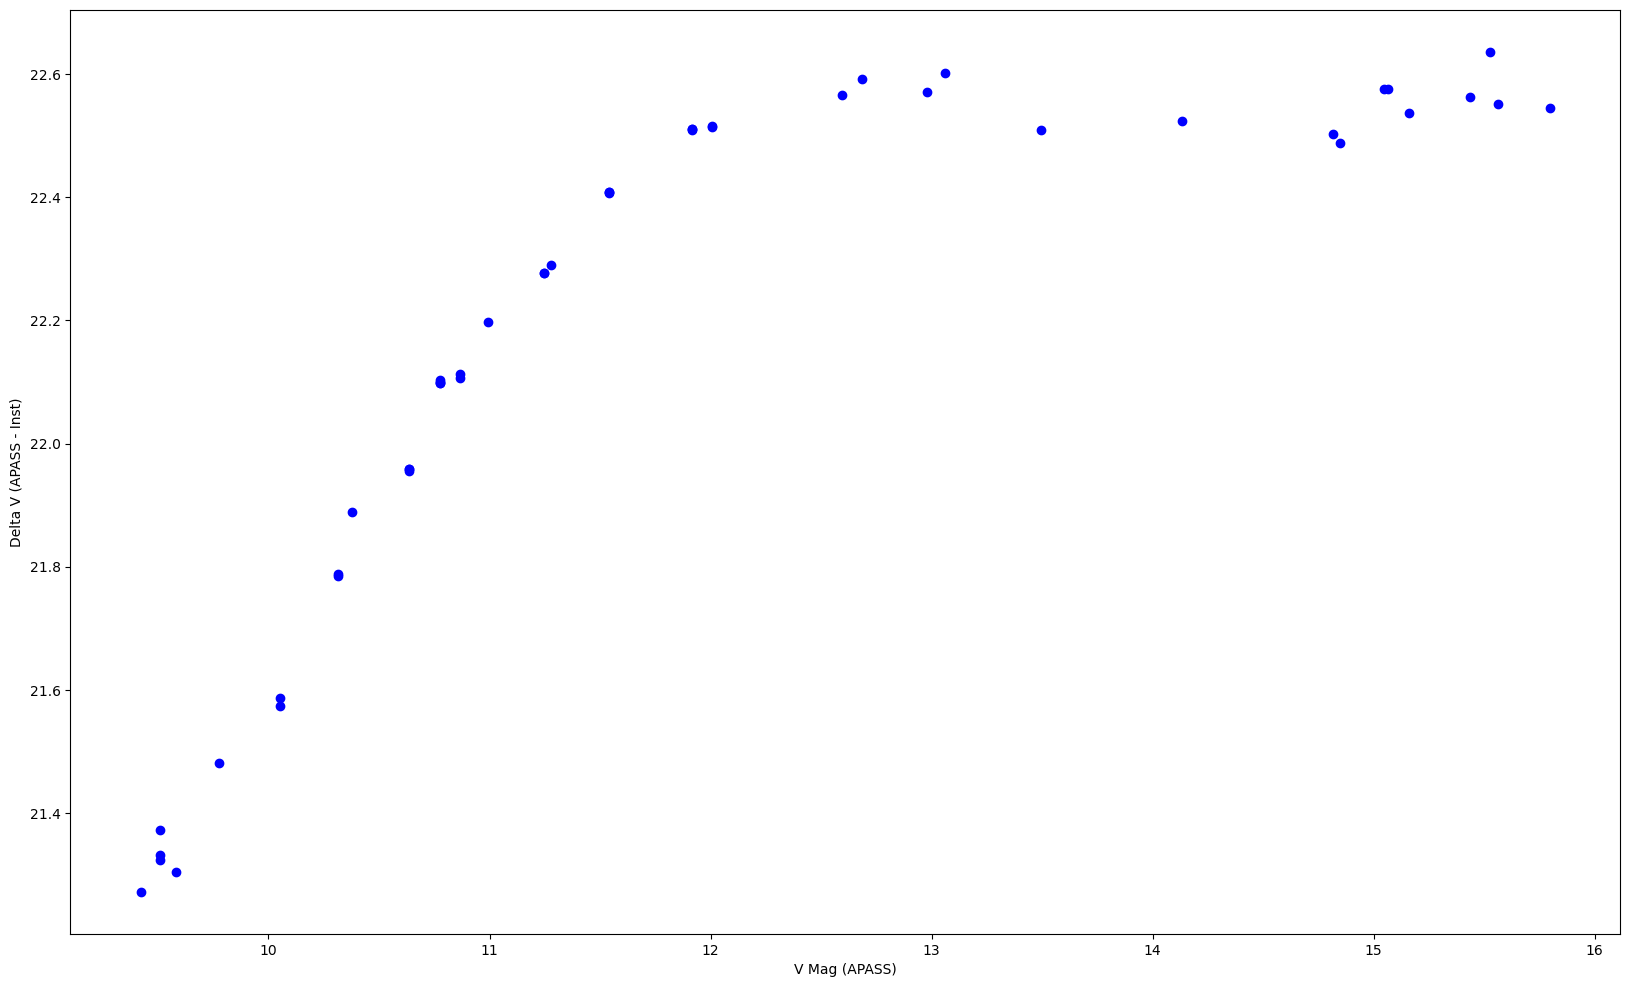

In [18]:
delta_mag = xmatch['Vmag'] - xmatch['instrumental_mag']

import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.plot(xmatch['Vmag'],delta_mag, 'bo')
plt.xlabel('V Mag (APASS)')
plt.ylabel('Delta V (APASS - Inst)')
plt.show

The magnitude difference between instrumental and calibrated magnitude (your Y-axis) *should* be a constant, which is the value of $kX + m_{\rm zp}$. In the figure above, you can see there are plenty of outlying points, and the bright stars deviate from the constant. The outliers are either stars whose photometry is bad (poor sky estimation, or contaminated by very close stars), or spurious detections (i.e not stars). The deviation of the bright stars is caused because they are saturated, and so we cannot accurately measure their flux.

Since $m = m_i - kX + m_{\rm zp}$, we can find the value of $-kX + m_{\rm zp}$. - which I'll call the *zeropoint* from now on - by calculating the **median** difference between the instrumental and calibrated magnitude. The median will be robust against the outliers - but we only want to do it for the non-saturated stars!

# Calculate the zero-point

> Calculate the median value of ```delta_mag```. **If you have evidence for saturated stars**, you can use a NumPy *mask* to only calculate the median of stars that are not saturated 

> The median value of ```delta_mag``` is our estimate of $-kX + m_{\rm zp}$ - i.e the value we want to add to our instrumental magnitudes to get a calibrated magnitude. You can add this value to the **instrumental_mag** column of the VMag_inst table easily using ```VMag_inst['calibrated_mag'] = VMag_inst['instrumental_mag'] + zp```, where ```zp``` is the median value you found.

<section class="challenge panel panel-success"> 
<div class="panel-heading">

<h2><span class="fa fa-pencil"></span> Determine your zeropoint mask</h2>

**Set the plotmask below to exclude any saturated stars.**
    
**Alternatively, if the crossmatch fails (usually due to a lack of stars) you can adopt 22.5 for V and 23.5 for B**

</div>
</section>


In [19]:
# First, just calculate the median:

zp = np.median(delta_mag)
print ('zeropoint = ', zp)

# We could also use a mask to exclude saturated points. Replace 21.5 and 21.0 
# with the upper/lower bounds of your 'good' data
plotmask = (delta_mag > 22.4) #& (delta_mag > 21.0)
delta_masked = delta_mag[plotmask]
zp1 = np.median(delta_masked)
print('Masked zeropoint = ',zp1)

zeropoint =  22.28374212422255
Masked zeropoint =  22.524032165597866


/home/jrees/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [20]:
zeropoint_v = zp1
# Now apply the zeropoint to the instrumental magnitudes
Vmag_inst['calibrated_mag'] = Vmag_inst['instrumental_mag'] + zeropoint_v

---------
# Other filters and making a CMD

If we repeat the above steps for other images, we can measure our stellar magnitudes in all of our other filters

<a id='BFilt'></a>
# The B-band data

 Assuming that you started with V, repeat the steps for your B-band data. Make a plot of the difference between instrumental B-band magnitude and APASS B-band magnitude. Calculate the offset needed to correct your instrumental mags (zeropoint).

 Finally, add your zeropoint to the **instrumental_mag** column of the B-band table to make a new **calibrated_mag** column.

The background has an average value of 437.5 and a standard deviation of 21.7 counts
 id     xcentroid          ycentroid      ...        peak               flux                mag         
--- ------------------ ------------------ ... ------------------ ------------------ --------------------
  1 1.6319028215260536 0.6166080106064797 ... 386.35662841796875  9.321030616760254  -2.4236598362567814
  2  14.93054835545889 0.8946910696313597 ...       272.12890625  4.800896167755127  -1.7033057832219014
  3  705.0194461900309  6.754693422555193 ... 262.59881591796875  2.329073667526245   -0.917958063215373
  4  405.5056172404814  7.217515978141549 ...  514.4757080078125  5.562541961669922  -1.8631832503782957
  5 10.753576916547845  7.871819041678856 ...    172.24169921875 1.0588090419769287 -0.06204410354134951
  6  837.4256017080476  12.22382118842533 ...  2369.407470703125  25.75043296813965   -3.526961339180215
  7 180.31549385530298  35.70138356261011 ... 302.66302490234375 3.60158705

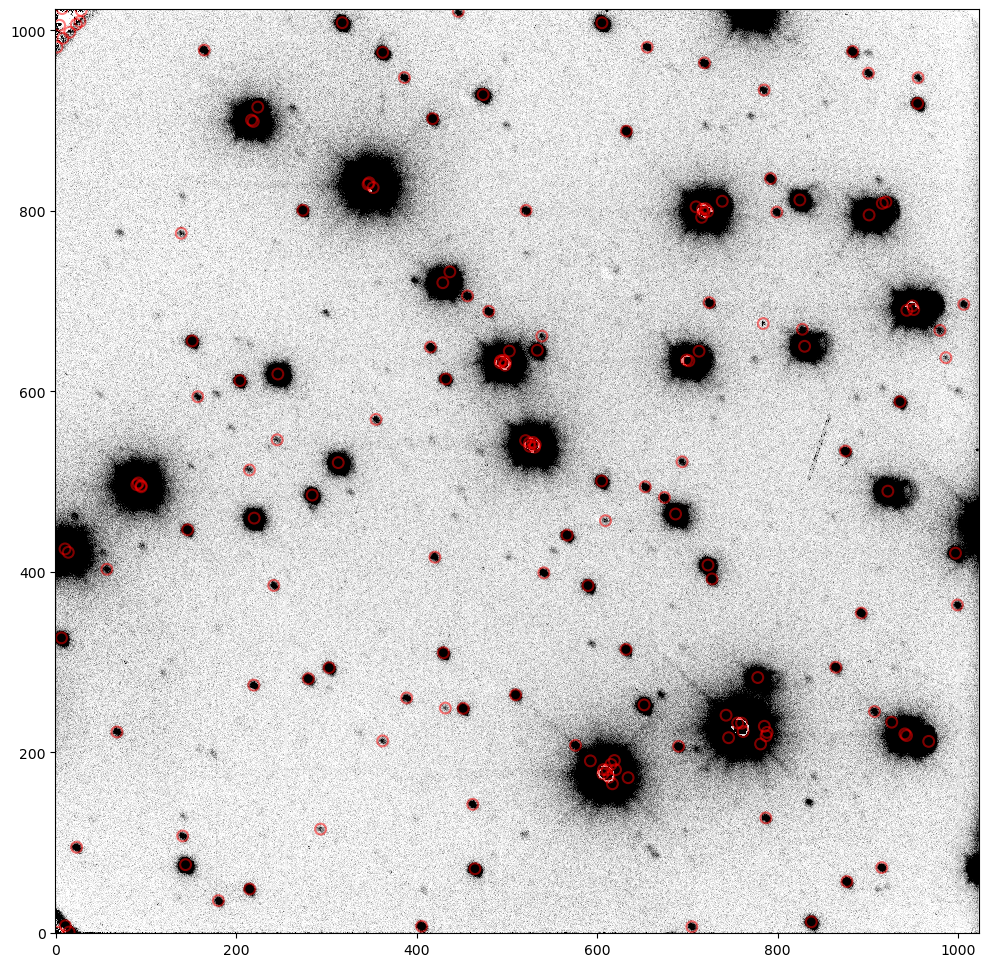

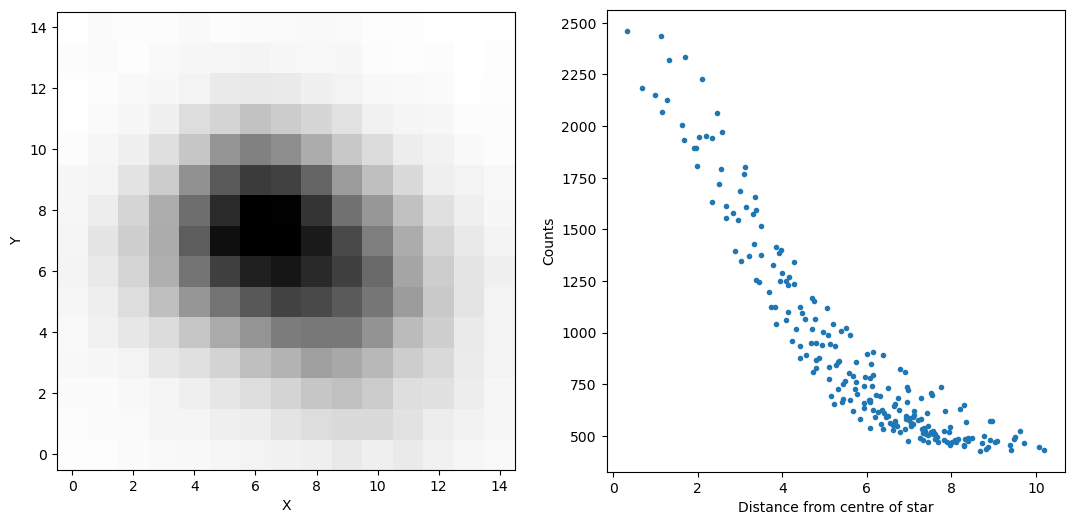

In [21]:
# Grab the data
ifile = '/home/jrees/DataReduction/20230720/Standards/d1116_os_bs_ff_bp_crj.fits'
data, header = fits.getdata(ifile,header=True)

# Measure the background
mean_background, median_background, background_standard_deviation = sigma_clipped_stats(data, sigma=3.0)

print("The background has an average value of {:.1f} and a standard deviation of {:.1f} counts".format(
    mean_background, background_standard_deviation))

# Find the stars 
daofind = DAOStarFinder(fwhm=fwhm, threshold=5*background_standard_deviation)
sources = daofind(data - median_background)
print(sources)

# Check everything looks good
radius=fwhm
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=radius)
norm = ImageNormalize(data, interval=AsymmetricPercentileInterval(5, 95))
fig = plt.figure(figsize=(15, 12))
apertures.plot(color='red', lw=1.5, alpha=0.5)
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

# Take a look at the FWHM in this image
measure_FWHM(data, sources)

# Time for photometry
Bmag_inst = aperture_photometry(data, header, sources, 15, 25, 35)



# Astrometry round 2

Let's repeat the astrometric solve for this second image

In [22]:
# Sort sources in ascending order
sources.sort('flux')
# Reverse to get descending order
sources.reverse()

image_width = 1024
image_height = 1024
wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                        image_width, image_height,
                                        solve_timeout=120)
print("Finished astrometric solve")
print("-----------------------------------------------------")

w = WCS(wcs_header)
Bmag_inst['RA'], Bmag_inst['DEC'] = w.wcs_pix2world(Bmag_inst['xcenter'],Bmag_inst['ycenter'],1)

Solving............................................Finished astrometric solve
-----------------------------------------------------


# Crossmatch with APASS

Perform the APASS crossmatch for your second filter

<function matplotlib.pyplot.show(close=None, block=None)>

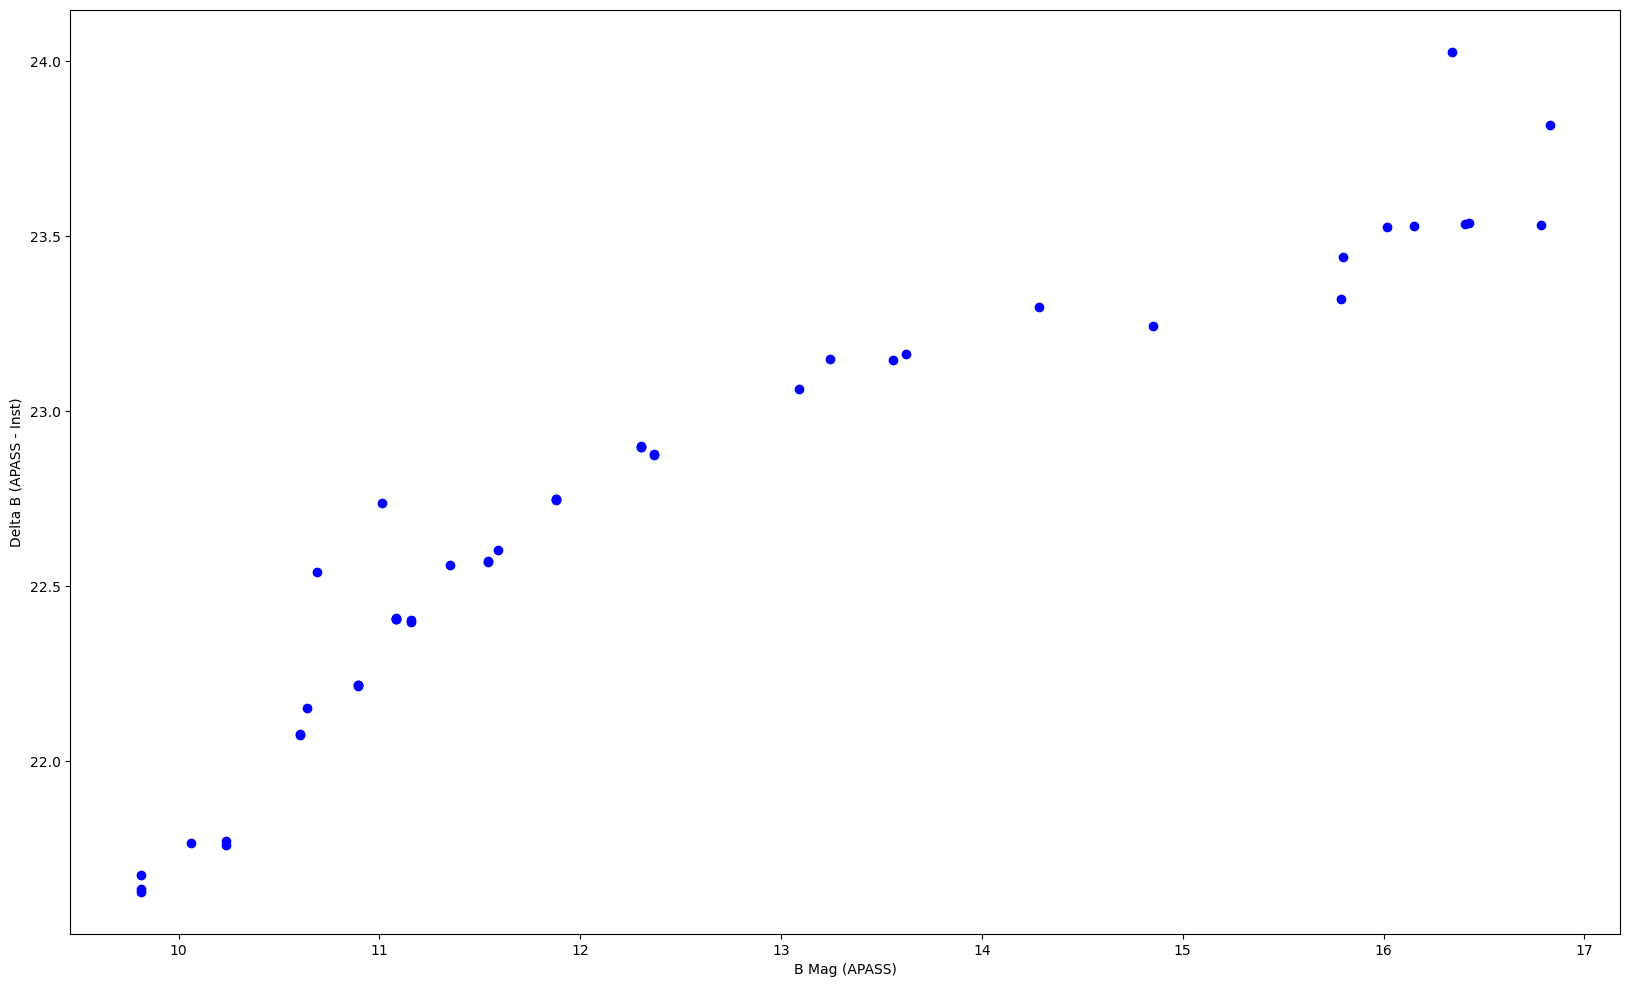

In [23]:
xmatch2 = XMatch.query(cat1=Vmag_inst, cat2='vizier:II/336/apass9', max_distance=2*u.arcsec, colRA1='RA', colDec1='DEC')
xmatch2

delta_mag = xmatch2['Bmag'] - xmatch2['instrumental_mag']

import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.plot(xmatch2['Bmag'],delta_mag, 'bo')
plt.xlabel('B Mag (APASS)')
plt.ylabel('Delta B (APASS - Inst)')
plt.show

In [24]:
# First, just calculate the median:

zp = np.median(delta_mag)
print ('zeropoint = ', zp)

# We could also use a mask to exclude saturated points. Replace 21.5 and 21.0 
# with the upper/lower bounds of your 'good' data
plotmask = (delta_mag > 23.4) #& (delta_mag > 21.0)
delta_masked = delta_mag[plotmask]
zp2 = np.median(delta_masked)
print('Masked zeropoint = ',zp2)

zeropoint_b = zp2
# Now apply the zeropoint to the instrumental magnitudes
Bmag_inst['calibrated_mag'] = Bmag_inst['instrumental_mag'] + zeropoint_b

zeropoint =  22.67060476336983
Masked zeropoint =  23.532852087827365


/home/jrees/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [25]:
Bmag_inst

<QTable length=174>
  id       xcenter            ycenter       ...   instrumental_mag    e_instrumental_mag    calibrated_mag  
             pix                pix         ...                                                             
int64      float64            float64       ...       float64              float64             float64      
----- ------------------ ------------------ ... ------------------- --------------------- ------------------
    1 1.6319028215260536 0.6166080106064797 ...  -5.694085423949961  0.005577652975795095 17.838766663877404
    2  14.93054835545889 0.8946910696313597 ...  -6.469657323759064 0.0035050069214828897   17.0631947640683
    3  705.0194461900309  6.754693422555193 ...  -6.065924269435491 0.0057017821977483766 17.466927818391873
    4  405.5056172404814  7.217515978141549 ...  -6.286674210086539  0.004777974393836267 17.246177877740827
    5 10.753576916547845  7.871819041678856 ...  -6.997127390901609  0.002510047008490749 16.535724696925755
    6  837.4256017080476  12.22382118842533 ...  -7.240464588137923  0.002369052034426947 16.292387499689443
    7 180.31549385530298  35.70138356261011 ... -4.5968357968678895  0.024773491061790404 18.936016290959476
  ...                ...                ... ...                 ...                   ...                ...
  167  4.364996238044587 1005.7491757979144 ...   -5.83708705757224  0.006244234624871857 17.695765030255124
  168 22.855700015457334 1006.8123387781872 ...  -6.660697205896792 0.0035844376096703873 16.872154881930573
  169  317.5768696220963 1008.6627392480486 ...  -7.678788748750193  0.001746952696498586 15.854063339077172
  170  605.3684902857327  1008.524196017077 ...  -7.726267867043424 0.0016862681978376901 15.806584220783941
  171 26.842962614644595 1009.8806273299656 ...  -6.576708222066849  0.003887889771998035 16.956143865760517
  172 28.284115960888233  1022.233800760144 ...  -5.043088438903533  0.011965520828462908 18.489763648923834
  173    446.17273009871 1021.1733919685173 ... -5.2131564944166655  0.010918220343594248   18.3196955934107
  174  7.078149604306925 1024.2250408874233 ...                 nan -0.012262593932146817                nan

# Crossmatching our calibrated magnitudes

Now you should have a two astropy tables: One with calibrated V-band magnitudes and one with calibrated B-band magnitudes. We need to cross-match these tables with each other, to find which stars in the V-band table match with stars in the B-band table. We can't use ```astroquery```'s Xmatch for this, since they are both local tables. Instead, we will use the ```SkyCoord``` object from astropy, which is meant to work with coordinates on the sky. 



In [27]:
from astropy.coordinates import SkyCoord
# Create a SkyCoord object for your first filter
coo_v = SkyCoord(Vmag_inst['RA'], Vmag_inst['DEC'], unit=u.deg)

# And for the second filter 
coo_b = SkyCoord(Bmag_inst['RA'], Bmag_inst['DEC'], unit=u.deg)

# match every entry in coo_v with the nearest entry in coo_b to identify the same stars in each catalogue
idx, distance_2d, distance_3d = coo_v.match_to_catalog_sky(coo_b)



TypeError: concatenate() got an unexpected keyword argument 'dtype'

In [ ]:
# using idx as a slice for the Bmag_inst table will sort it so that Bmag_inst[0] is the closest match to Vmag_inst[0]
Bmag_inst = Bmag_inst[idx]

# And finally we have to ensure the closest match is actually useful. 
# Some of the 'closest matches' might actually be very far away. 
dist_mask = distance_2d < 3 * u.arcsec
Bmag_inst = Bmag_inst[dist_mask]
Vmag_inst = Vmag_inst[dist_mask]


# Plotting a CMD 

 If we want to plot a CMD from our data, we can extract the calibrated magnitudes, calculate ```B-V``` and plot a colour-magnitude diagram of ```B-V``` against ```V```. Your plot should look something like the one below, which is for the cluster NGC 7789.

<img src="./images/CMD.png" style="margin: 0px" width=750px/>


In [ ]:
B = Bmag_inst['calibrated_mag']
V = Vmag_inst['calibrated_mag']

plt.figure(figsize=(20,12))
plt.plot(B-V,V, 'bo')
plt.xlabel('B-V')
plt.ylabel('V Mag')
plt.gca().invert_yaxis()
plt.show

# Other filters

If you have data in other filters (and time!) you can go ahead and repeat the above steps for the other filters.


In [ ]:
# YOUR CODE HERE
#R
# Grab the data
ifile = '/Users/jrees/Python/Nickel_Photometry/Data/d1069_os_bs_ff_bp_crj.fits'
data, header = fits.getdata(ifile,header=True)

# Measure the background
mean_background, median_background, background_standard_deviation = sigma_clipped_stats(data, sigma=3.0)

print("The background has an average value of {:.1f} and a standard deviation of {:.1f} counts".format(
    mean_background, background_standard_deviation))

# Find the stars 
daofind = DAOStarFinder(fwhm=6.0, threshold=5*background_standard_deviation)
sources = daofind(data - median_background)
print(sources)

# Check everything looks good
radius=6
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=radius)
norm = ImageNormalize(data, interval=AsymmetricPercentileInterval(5, 95))
fig = plt.figure(figsize=(15, 12))
apertures.plot(color='red', lw=1.5, alpha=0.5)
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

# Take a look at the FWHM in this image
measure_FWHM(data, sources)

# Time for photometry
Rmag_inst = aperture_photometry(data, header, sources, 15, 25, 35)

Rmag_inst['RA'], Rmag_inst['DEC'] = w.wcs_pix2world(Rmag_inst['xcenter'],Rmag_inst['ycenter'],1)

coo_r = SkyCoord(Rmag_inst['RA'], Rmag_inst['DEC'], unit=u.deg)
coo=SkyCoord(StanRA,StanDEC,unit=u.deg)

#change standard Vmag depending on standard star 
Stan_Rmag=10.884
d2d = coo.separation(coo_r)
zeropoint_r= Stan_Rmag-Rmag_inst[np.where(d2d == d2d.min())]['instrumental_mag']
print(zeropoint_r[0])

exptime = 10
sky_brightness = zeropoint_r[0] - 2.5*math.log10((mean_background/exptime)/(0.18*0.18))
print ("Sky Brightness = ", sky_brightness)

# And apply the zeropoint
Rmag_inst['calibrated_mag'] = Rmag_inst['instrumental_mag'] + zeropoint_r



In [ ]:
# YOUR CODE HERE
#R
# Grab the data
ifile = '/Users/jrees/Python/Nickel_Photometry/Data/d1070_os_bs_ff_bp_crj.fits'
data, header = fits.getdata(ifile,header=True)

# Measure the background
mean_background, median_background, background_standard_deviation = sigma_clipped_stats(data, sigma=3.0)

print("The background has an average value of {:.1f} and a standard deviation of {:.1f} counts".format(
    mean_background, background_standard_deviation))

# Find the stars 
daofind = DAOStarFinder(fwhm=6.0, threshold=5*background_standard_deviation)
sources = daofind(data - median_background)
#print(sources)

# Check everything looks good
radius=6
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=radius)
norm = ImageNormalize(data, interval=AsymmetricPercentileInterval(5, 95))
fig = plt.figure(figsize=(15, 12))
apertures.plot(color='red', lw=1.5, alpha=0.5)
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

# Take a look at the FWHM in this image
#measure_FWHM(data, sources)

# Time for photometry
Imag_inst = aperture_photometry(data, header, sources, 15, 25, 35)

Imag_inst['RA'], Imag_inst['DEC'] = w.wcs_pix2world(Imag_inst['xcenter'],Imag_inst['ycenter'],1)

coo_i = SkyCoord(Imag_inst['RA'], Imag_inst['DEC'], unit=u.deg)
coo=SkyCoord(StanRA,StanDEC,unit=u.deg)

#change standard Vmag depending on standard star 
Stan_Imag=10.961
d2d = coo.separation(coo_i)
zeropoint_i= Stan_Imag-Imag_inst[np.where(d2d == d2d.min())]['instrumental_mag']
print(zeropoint[0])

exptime = 10
sky_brightness = zeropoint_i[0] - 2.5*math.log10((mean_background/exptime)/(0.18*0.18))
print ("Sky Brightness = ", sky_brightness)

# And apply the zeropoint
Imag_inst['calibrated_mag'] = Imag_inst['instrumental_mag'] + zeropoint_i


In [ ]:
# And now let's do some clusters
# V
ifile = '/Users/jrees/Python/Nickel_Photometry/Data/d1124_os_bs_ff_bp_crj.fits'
data, header = fits.getdata(ifile,header=True)

# Measure the background
mean_background, median_background, background_standard_deviation = sigma_clipped_stats(data, sigma=3.0)

print("The background has an average value of {:.1f} and a standard deviation of {:.1f} counts".format(
    mean_background, background_standard_deviation))

# Find the stars 
daofind = DAOStarFinder(fwhm=6.0, threshold=5*background_standard_deviation)
sources = daofind(data - median_background)
#print(sources)

# Check everything looks good
radius=6
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=radius)
norm = ImageNormalize(data, interval=AsymmetricPercentileInterval(5, 95))
fig = plt.figure(figsize=(15, 12))
apertures.plot(color='red', lw=1.5, alpha=0.5)
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

# Take a look at the FWHM in this image
#measure_FWHM(data, sources)

# Time for photometry
Vmag_inst = aperture_photometry(data, header, sources, 15, 25, 35)


exptime = 100
sky_brightness = zeropoint_v[0] - 2.5*math.log10((mean_background/exptime)/(0.18*0.18))
print ("Sky Brightness = ", sky_brightness)

# And apply the zeropoint
Vmag_inst['calibrated_mag'] = Vmag_inst['instrumental_mag'] + zeropoint_v


# B
ifile = '/Users/jrees/Python/Nickel_Photometry/Data/d1120_os_bs_ff_bp_crj.fits'
data, header = fits.getdata(ifile,header=True)

# Measure the background
mean_background, median_background, background_standard_deviation = sigma_clipped_stats(data, sigma=3.0)

print("The background has an average value of {:.1f} and a standard deviation of {:.1f} counts".format(
    mean_background, background_standard_deviation))

# Find the stars 
daofind = DAOStarFinder(fwhm=6.0, threshold=5*background_standard_deviation)
sources = daofind(data - median_background)
#print(sources)

# Check everything looks good
radius=6
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=radius)
norm = ImageNormalize(data, interval=AsymmetricPercentileInterval(5, 95))
fig = plt.figure(figsize=(15, 12))
apertures.plot(color='red', lw=1.5, alpha=0.5)
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

# Take a look at the FWHM in this image
#measure_FWHM(data, sources)

# Time for photometry
Bmag_inst = aperture_photometry(data, header, sources, 15, 25, 35)


exptime = 100
sky_brightness = zeropoint_b[0] - 2.5*math.log10((mean_background/exptime)/(0.18*0.18))
print ("Sky Brightness = ", sky_brightness)

# And apply the zeropoint
Bmag_inst['calibrated_mag'] = Bmag_inst['instrumental_mag'] + zeropoint_b

In [ ]:
# Create a SkyCoord object for your first filter
coo_v2 = SkyCoord(Vmag_inst['RA'], Vmag_inst['DEC'], unit=u.deg)

# And for the second filter 
coo_b2 = SkyCoord(Bmag_inst['RA'], Bmag_inst['DEC'], unit=u.deg)


# match every entry in coo_v with the nearest entry in coo_b to identify the same stars in each catalogue
idx, distance_2d, distance_3d = coo_v2.match_to_catalog_sky(coo_b2)

# using idx as a slice for the Bmag_inst table will sort it so that Bmag_inst[0] is the closest match to Vmag_inst[0]
Bmag_inst = Bmag_inst[idx]

# And finally we have to ensure the closest match is actually useful. 
# Some of the 'closest matches' might actually be very far away. 
dist_mask = distance_2d < 3 * u.arcsec
Bmag_inst = Bmag_inst[dist_mask]
Vmag_inst = Vmag_inst[dist_mask]

B = Bmag_inst['calibrated_mag']
V = Vmag_inst['calibrated_mag']

plt.figure(figsize=(20,12))
plt.plot(B-V,V, 'bo')
plt.xlabel('B-V')
plt.ylabel('V Mag')
plt.gca().invert_yaxis()
plt.show